STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Convolutional Variational Autoencoder for MNIST

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.1+cu111



## Imports

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [13]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [16]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:0


In [17]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [18]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)

In [19]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [20]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),   # Fully connected layer, it take `z or encoded` is 2 back into 3136
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()    # the pixels are in zero-one range
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())   # Sampling epsilson from random normal distribution, z_mu.size(0)is 256 sample, z_mu is mean values
        z = z_mu + eps * torch.exp(z_log_var/2.)     # `torch.exp(z_log_var/2.)` this is the standard deviation which is log-var trick and this allows us to have positive and negative values
        return z
        
    def forward(self, x):
        x = self.encoder(x)     # encoder
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)     # reparameterization
        decoded = self.decoder(encoded)     # decoder
        return encoded, z_mean, z_log_var, decoded    # need all four of those for back propagation

In [21]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [22]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0234 | Loss: 183.5786


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f47e73335e0>
Traceback (most recent call last):
  File "/home/nuttunk/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/nuttunk/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
if w.is_alive():    
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f47e73335e0>
Traceback (most recent call last):
  File "/home/nuttunk/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/nuttunk/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
   

Epoch: 001/050 | Batch 0050/0234 | Loss: 56.7570
Epoch: 001/050 | Batch 0100/0234 | Loss: 52.0261
Epoch: 001/050 | Batch 0150/0234 | Loss: 53.2677
Epoch: 001/050 | Batch 0200/0234 | Loss: 48.3644
Time elapsed: 0.29 min
Epoch: 002/050 | Batch 0000/0234 | Loss: 48.0930
Epoch: 002/050 | Batch 0050/0234 | Loss: 46.8422
Epoch: 002/050 | Batch 0100/0234 | Loss: 45.4181
Epoch: 002/050 | Batch 0150/0234 | Loss: 43.1443
Epoch: 002/050 | Batch 0200/0234 | Loss: 44.5680
Time elapsed: 0.36 min
Epoch: 003/050 | Batch 0000/0234 | Loss: 43.5281
Epoch: 003/050 | Batch 0050/0234 | Loss: 41.3858
Epoch: 003/050 | Batch 0100/0234 | Loss: 43.2711
Epoch: 003/050 | Batch 0150/0234 | Loss: 41.9821
Epoch: 003/050 | Batch 0200/0234 | Loss: 43.4645
Time elapsed: 0.44 min
Epoch: 004/050 | Batch 0000/0234 | Loss: 43.1134
Epoch: 004/050 | Batch 0050/0234 | Loss: 41.0985
Epoch: 004/050 | Batch 0100/0234 | Loss: 41.9705
Epoch: 004/050 | Batch 0150/0234 | Loss: 41.8873
Epoch: 004/050 | Batch 0200/0234 | Loss: 39.4068


## Evaluation

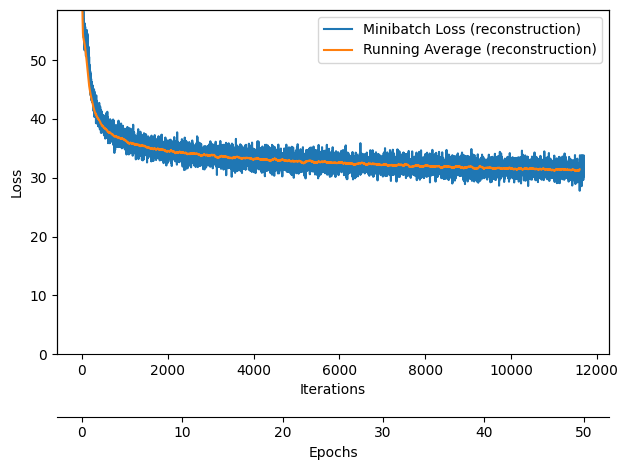

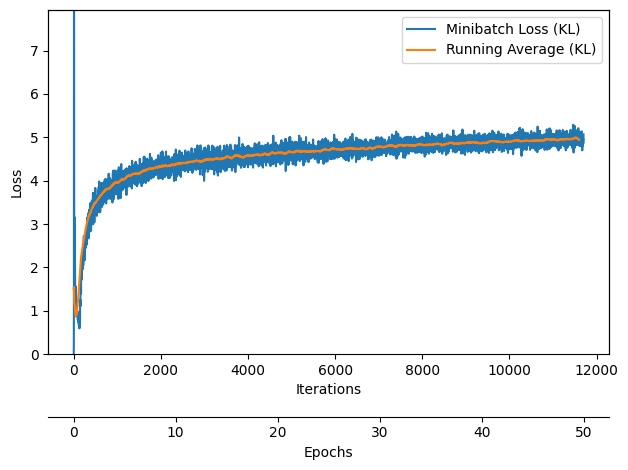

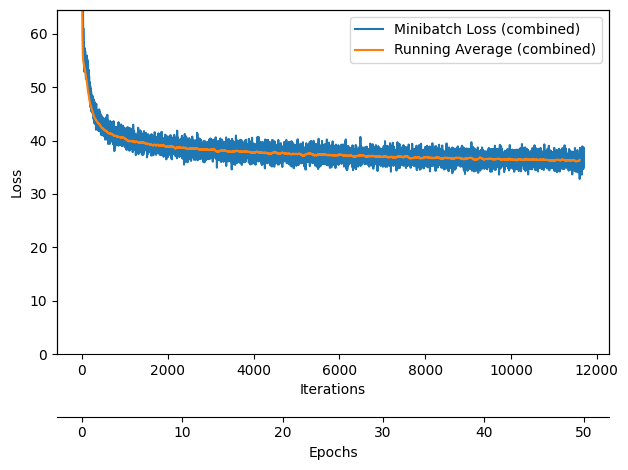

In [23]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

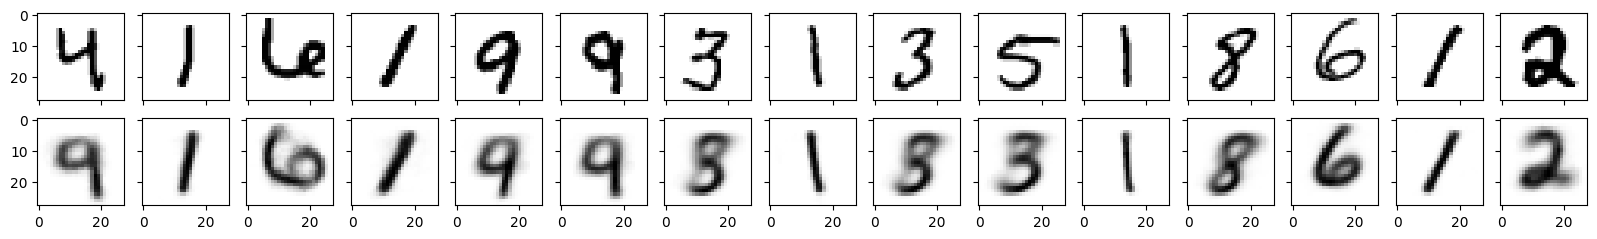

In [24]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')           

In [25]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE)

plt.legend()
plt.show()

NameError: name 'NUM_CLASSES' is not defined

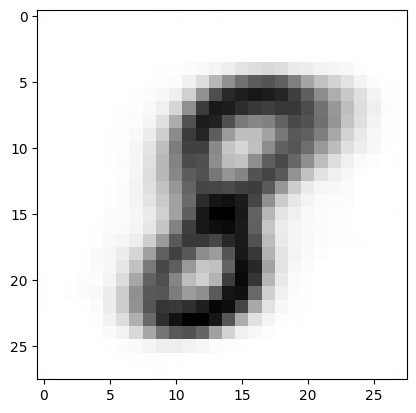

In [26]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

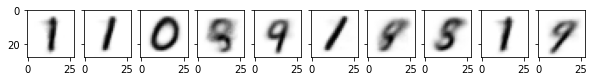

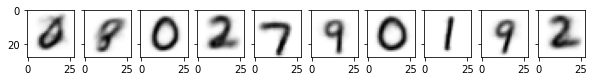

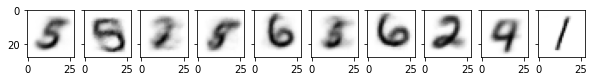

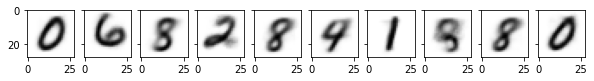

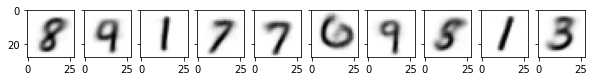

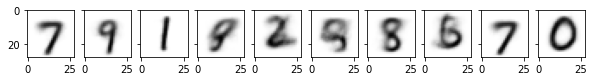

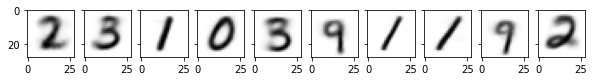

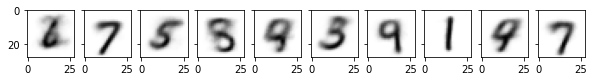

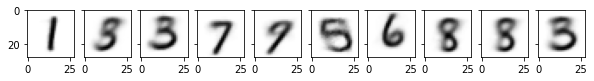

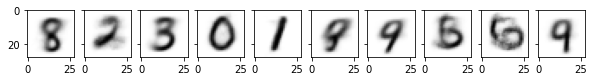

In [15]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()